In [1]:
%matplotlib inline
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from gravdark import LightCurve, hat7_params
from gravdark.lightcurve import concatenate_light_curves

In [138]:
len(h7_transits)

626

In [189]:
h7_path = glob('/Users/bmmorris/data/gravdark/hat7/*slc.fits')
h7_lc_whole = LightCurve.from_raw_fits(h7_path, name='HAT-P-7 b')

h7_masked = LightCurve(**h7_lc_whole.mask_out_of_transit(hat7_params(), oot_duration_fraction=0.5))
h7_transits = h7_masked.get_transit_light_curves(hat7_params())
for transit in h7_transits:
    transit.remove_linear_baseline(hat7_params())
h7 = concatenate_light_curves(h7_transits)

phase = h7.phases(hat7_params())
residuals = h7.fluxes - h7.transit_model(hat7_params())

binstat = binned_statistic(phase, residuals, statistic='median', bins=100)
errstat = binned_statistic(phase, residuals, statistic='std', bins=100)
countstat = binned_statistic(phase, residuals, statistic='count', bins=100)
error = 2 * errstat.statistic/np.sqrt(countstat.statistic)

bincenters = 0.5 * (binstat.bin_edges[1:] + binstat.bin_edges[:-1])

x, y = bincenters, binstat.statistic - np.median(binstat.statistic)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/time/core.py:849: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd1 = apply_method(jd1)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/time/core.py:850: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd2 = apply_method(jd2)
/Users/bmmorris/git/gravdark/gravdark/lightcurve.py:373: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  fluxes=self.fluxes[start_ind:end_ind],
/Users/bmmorris/git/gravdark/gravdark/lightcurve.py:374: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  errors=self.errors[start_ind:end_ind],
/Users/bmmorris/git/gravdark/gravdark/lightcurve.py:375: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an er

(-0.0001, 0.0001)

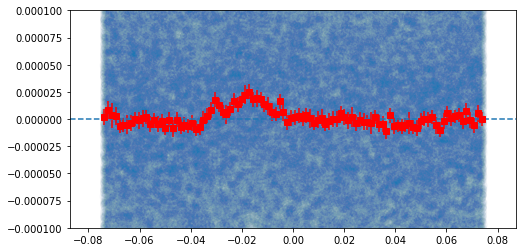

In [190]:
plt.figure(figsize=(8, 4))
plt.scatter(phase, residuals, alpha=0.01)
plt.errorbar(x, y, yerr=error, fmt='s', color='r')
plt.axhline(0, ls='--')

#plt.axvline(min_phase, ls='--', color='w')
#plt.axvline(max_phase, ls='--', color='w')

plt.ylim([-0.0001, 0.0001])

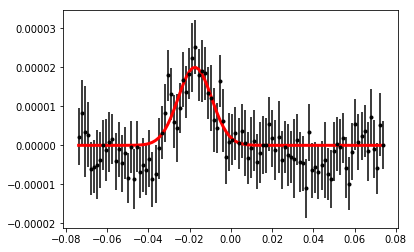

In [191]:
def gaussian(p, x):
    amp, t0, sig = p
    return amp * np.exp(-0.5 * (t0 - x)**2/sig**2)

from scipy.optimize import fmin_l_bfgs_b

def chi2(p, x, y, yerr):
    return np.sum(np.power((gaussian(p, x) - y)/yerr, 2))

initp = [-0.02, 25e-6, 0.01]
result = fmin_l_bfgs_b(chi2, initp, args=(x, y, error), approx_grad=True,
                       bounds=([10e-6, 50e-6], [-0.04, 0], [0.001, 0.05]))[0]

plt.errorbar(x, y, error, fmt='.', color='k')
plt.plot(x, gaussian(result, x), color='r', lw=3)
plt.show()

In [192]:
np.savetxt("data/residuals.txt", np.vstack([x, y, error]).T)

In [11]:
params = hat7_params()
[result[1] * params.per + params.t0]

[2454954.3201096719]

In [27]:
import sys
sys.path.insert(0, '/Users/bmmorris/git/friedrich')
from friedrich.orientation import times_to_occulted_lat_lon
times = (np.array([result[1] * params.per + params.t0]) + 
         np.array([-result[2], 0, result[2]]))
lat_rad, lon_rad = times_to_occulted_lat_lon(times, params)

In [51]:
lat, lon = np.degrees([lat_rad, lon_rad])
lat, lon

(array([-24.04566378, -23.6350629 , -23.33284229]),
 array([-36.97073715, -29.70856037, -22.98631578]))

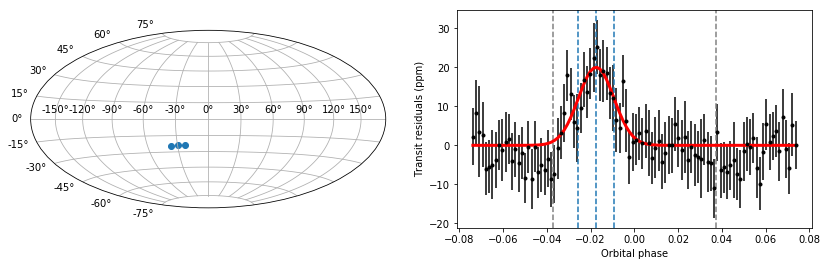

In [145]:
#fig, ax = plt.subplots(1, 2)
fig = plt.figure(figsize=(14, 4))
ax0 = fig.add_subplot(121, projection='hammer')
ax1 = fig.add_subplot(122)
ax = [ax0, ax1]
ax[0].scatter(lon_rad, lat_rad)
ax[0].grid()

for t in [result[1]-result[2], result[1], result[1]+result[2]]:
    ax[1].axvline(t, ls='--')
    
for t in np.array([-params.duration/2, params.duration/2])/params.per:
    ax[1].axvline(t, ls='--', color='gray')

ax[1].errorbar(x, y*1e6, error*1e6, fmt='.', color='k')
ax[1].plot(x, gaussian(result, x)*1e6, color='r', lw=3)
ax[1].set(xlabel='Orbital phase', ylabel='Transit residuals (ppm)')
# ax[1].set_aspect(2000)
fig.savefig('plots/map.png', bbox_inches='tight', dpi=150)
plt.show()

# Email this to Rory

In [89]:
1./np.tan(np.radians(lon_rad[1]))

-110.49733444414646

In [96]:
360 * result[1]

-6.2739998443280038

In [105]:
eps_deg = lon[1] - 360 * result[1]
eps_rad = np.radians(eps_deg)
eps_deg, eps_rad

(-23.4345605271726, -0.40901023995705993)

In [107]:
1./np.tan(eps_rad)

2.3070446656868087

### Break up into quarters

In [147]:
len(h7_transits) // 4

156

In [159]:
int(i/4*n_transits), int((i+1)/4*n_transits)

(156, 313)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/time/core.py:849: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd1 = apply_method(jd1)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/time/core.py:850: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd2 = apply_method(jd2)
/Users/bmmorris/git/gravdark/gravdark/lightcurve.py:373: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  fluxes=self.fluxes[start_ind:end_ind],
/Users/bmmorris/git/gravdark/gravdark/lightcurve.py:374: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  errors=self.errors[start_ind:end_ind],
/Users/bmmorris/git/gravdark/gravdark/lightcurve.py:375: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an er

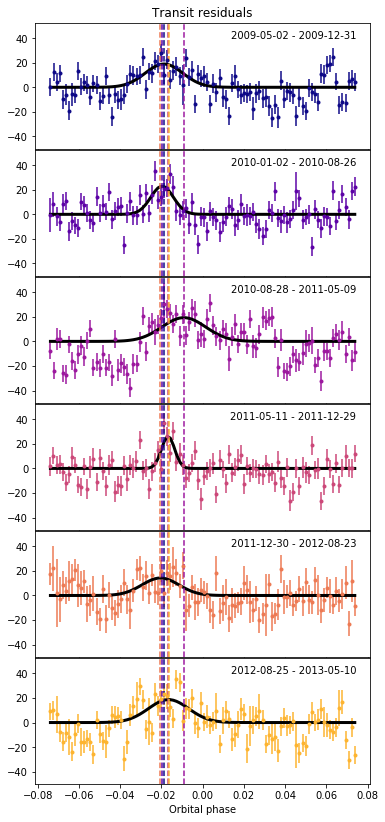

In [182]:
h7_path = glob('/Users/bmmorris/data/gravdark/hat7/*slc.fits')
h7_lc_whole = LightCurve.from_raw_fits(h7_path, name='HAT-P-7 b')

h7_masked = LightCurve(**h7_lc_whole.mask_out_of_transit(hat7_params(), oot_duration_fraction=0.5))
h7_transits = h7_masked.get_transit_light_curves(hat7_params())

nbins = 6
fig, ax = plt.subplots(nbins, 1, figsize=(6, 14), sharey=True, sharex=True)
n_transits = len(h7_transits)
centers = []
colors = [plt.cm.plasma(i/nbins) for i in range(nbins)]

for i, c in zip(range(nbins), colors):
    h7_quarter_transits = h7_transits[int(i/nbins*n_transits):int((i+1)/nbins*n_transits)]
    for transit in h7_quarter_transits:
        transit.remove_linear_baseline(hat7_params())
    
    h7 = concatenate_light_curves(h7_quarter_transits)

    phase = h7.phases(hat7_params())
    residuals = h7.fluxes - h7.transit_model(hat7_params())

    binstat = binned_statistic(phase, residuals, statistic='median', bins=100)
    errstat = binned_statistic(phase, residuals, statistic='std', bins=100)
    countstat = binned_statistic(phase, residuals, statistic='count', bins=100)
    error = errstat.statistic/np.sqrt(countstat.statistic)
    bincenters = 0.5 * (binstat.bin_edges[1:] + binstat.bin_edges[:-1])

    x, y = bincenters, binstat.statistic - np.median(binstat.statistic)
    
    initp = [-0.02, 25e-6, 0.01]
    result = fmin_l_bfgs_b(chi2, initp, args=(x, y, error), approx_grad=True,
                           bounds=([10e-6, 50e-6], [-0.035, 0], [0.001, 0.05]))[0]

    ax[i].annotate("{0} - {1}".format(h7.times.min().datetime.date(), 
                                      h7.times.max().datetime.date()), 
                   xy=(phase.max(), 40), ha='right')
    
    centers.append(result[1])
    ax[i].errorbar(x, y*1e6, error*1e6, fmt='.', color=c)#, color='k')
    ax[i].plot(x, gaussian(result, x)*1e6, color='k', lw=3)

for center, c in zip(centers, colors):
    for i in range(nbins):
        ax[i].axvline(center, ls='--', color=c)
    
fig.subplots_adjust(hspace=0.01)
ax[nbins-1].set(xlabel='Orbital phase')
ax[0].set(title='Transit residuals')
fig.savefig('plots/consistency.png', bbox_inches='tight', dpi=200)